<a href="https://colab.research.google.com/github/AmineBAA/Deep-Insights_Neural-Network/blob/main/TCAV_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCAV for CIFAR10

## 1. Libraries

In [44]:
pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.0 MB/s eta 0:00:00


In [45]:
from captum.concept._core.concept import Concept, ConceptInterpreter

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16604029773112862047
 xla_global_id: -1]

In [2]:
!git clone https://github.com/pnxenopoulos/cav-keras.git
!cp -R cav-keras/cav cav/

fatal: destination path 'cav-keras' already exists and is not an empty directory.


In [3]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.datasets import cifar100, cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

from cav.tcav import *

np.random.seed(1996)

## 2. Dataset

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Keep ships (8) from CIFAR-10
interested_class = y_train == [8]
interested_class_indx = [i for i, x in enumerate(interested_class) if x]
x_train_class_one = x_train[interested_class_indx]
other = y_train == [2]
other_indx = [i for i, x in enumerate(other) if x]
x_train_class_two = x_train[other_indx]

x_train = np.append(x_train_class_one, x_train_class_two, axis = 0)
y_train = [1] * 5000
y_train = y_train + [0] * 5000

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

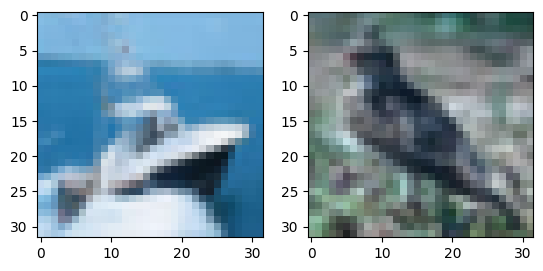

In [5]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[0])
axarr[1].imshow(x_train[7777])

In [6]:
(x_train_concept, y_train_concept), (x_test_concept, y_test_concept) = cifar100.load_data()

# keep sea (71) from CIFAR-100
concept = y_train_concept == [71]
indices = concept
indx_to_use = [i for i, x in enumerate(indices) if x]

x_train_concept = x_train_concept[indx_to_use]

## 3. Model setup

In [31]:
batch_size = 32
epochs = 1

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# initiate optimizer
opt = keras.optimizers.Adam(lr=0.001)

# train the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [32]:
x_train = np.array(x_train)
y_train = np.array(y_train)


In [33]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True)

Train on 10000 samples
10000/10000 [==============================] - 63s 6ms/sample - loss: 0.3468 - accuracy: 0.8476


In [34]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 32)        0         
                                                     

In [36]:
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

layer_name = 'conv2d_4'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

grads = K.gradients(loss, model.input)[0]

## 4. TCAV

In [37]:
mymodel=model

In [38]:
tcav_obj = TCAV()
tcav_obj.set_model(mymodel)

In [72]:
# Define the concepts
x_train_concept = np.array(x_train_concept)

In [39]:
tcav_obj.split_model(bottleneck = 0, conv_layer = True)
tcav_obj.train_cav(x_train_concept)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [40]:
tcav_obj.calculate_sensitivity(x_train, y_train)
tcav_obj.print_sensitivity()

The sensitivity of class 1 is  0.7588
The sensitivity of class 0 is  0.147
